In [3]:
# !pip install pandas-summary ipython fastai==0.7
! data/bulldozer

    100% |████████████████████████████████| 122kB 1.5MB/s ta 0:00:01
    100% |████████████████████████████████| 496.4MB 90kB/s  eta 0:00:01  8% |██▊                             | 42.2MB 38.4MB/s eta 0:00:12                         | 84.5MB 75.7MB/s eta 0:00:06    19% |██████▏                         | 96.4MB 34.8MB/s eta 0:00:12    22% |███████                         | 110.0MB 32.9MB/s eta 0:00:12    33% |██████████▋                     | 165.2MB 37.1MB/s eta 0:00:09    37% |████████████                    | 187.2MB 36.7MB/s eta 0:00:09��███████▍               | 253.7MB 36.9MB/s eta 0:00:07��███████▊               | 258.8MB 38.0MB/s eta 0:00:07    54% |█████████████████▎              | 268.7MB 33.2MB/s eta 0:00:07    61% |███████████████████▋            | 304.9MB 34.6MB/s eta 0:00:06    73% |███████████████████████▋        | 366.9MB 8.0MB/s eta 0:00:17    75% |████████████████████████▏       | 374.7MB 35.1MB/s eta 0:00:04    79% |█████████████████████████▍      | 393.1MB 36.3MB/s eta

  Found existing installation: torch 1.0.0
    Uninstalling torch-1.0.0:
      Successfully uninstalled torch-1.0.0
  Found existing installation: fastai 1.0.39
    Uninstalling fastai-1.0.39:
      Successfully uninstalled fastai-1.0.39
You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/bin/sh: 1: data/bulldozer: not found


In [5]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import IPython

from sklearn import metrics

In [15]:
PATH = '../input/train/'
# Kaggle Kernel
# !mkdir data && cp -r ../input/train data/bulldozer
# !ls data/bulldozer -a

In [17]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])
# ! ls ../input/train
# df_raw = pd.read_feather('tmp/bulldozers-raw')

In [18]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [19]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [20]:
# df_raw.saledate.head
add_datepart(df_raw, 'saledate')

In [21]:
# df_raw.saleYear.head()
# display_all(df_raw.tail().transpose())
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [22]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [ ]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [23]:
x, y, nas = proc_df(df_raw, 'SalePrice')

In [24]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x, y)
m.score(x, y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 32s, sys: 660 ms, total: 1min 33s
Wall time: 48.5 s


0.9831769007534854

In [25]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()
n_valid = 12000
n_trn = len(x) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(x, n_trn)
y_train, y_valid = split_vals(y, n_trn)
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [26]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [27]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x, y)
m.score(x, y)
print_score(m)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 32s, sys: 552 ms, total: 1min 33s
Wall time: 48.3 s
[0.09026421404444274, 0.09241362623897796, 0.9829719061133488, 0.9847482387618746]


In [28]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [29]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [30]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 3.71 s, sys: 4 ms, total: 3.72 s
Wall time: 2 s
[0.01113654527794266, 7.758866323398177, 0.9724593716649698, -106.5089234497993]


In [31]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.05126088455798645, 7.7474884218367235, 0.4164943543776164, -106.19384415750854]


In [32]:
draw_tree(m.estimators_[0], df_trn, precision=3)

NameError: name 'IPython' is not defined

In [ ]:
?IPython

In [33]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.9777590881479203e-05, 7.7601249148834635, 0.9999999131400354, -106.54380503804514]


In [34]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.011181925316750822, 7.760042090020335, 0.9722344650838632, -106.54150939113329]


In [35]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([2.3151687 , 2.28219125, 2.2876942 , 2.28498369, 2.23992874,
        2.29032725, 2.2876942 , 2.19226208, 2.25239066, 2.29288697]),
 2.272552773332455,
 9.104979856318357)

In [36]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, 
                          oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.009614346288249571, 7.762015379925478, 0.979473618752666, -106.5962094955306, 0.8530898250234437]


In [ ]:
# df_trn, y_trn = proc_df(df_raw, 'SalePrice')
# X_train, X_valid = split_vals(df_trn, n_trn)
# y_train, y_valid = split_vals(y_trn, n_trn)
# set_rf_samples(20000)

In [41]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
37,Coupler_System,0.201599
5,YearMade,0.198433
13,ProductSize,0.123058
14,fiProductClassDesc,0.103632
63,saleElapsed,0.071443
2,ModelID,0.063132
0,SalesID,0.051295
8,fiModelDesc,0.031307
9,fiBaseModel,0.021162
10,fiSecondaryDesc,0.018588


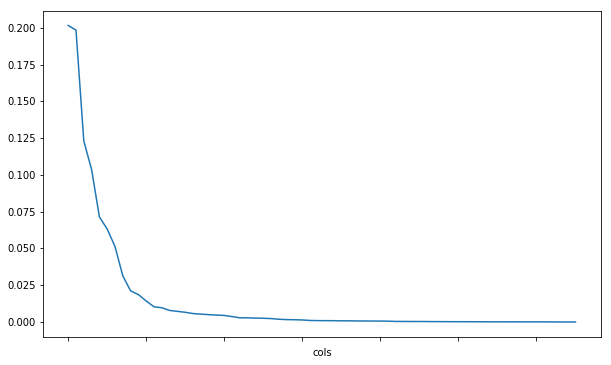

In [42]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

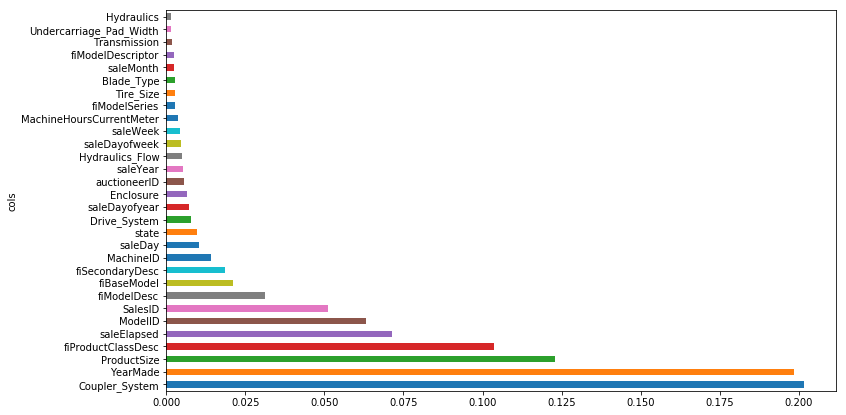

In [44]:
 def plot_fi(fi):
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);
